# Divvy Bike Share Project Remake
This is my Divvy Bike Project Remake. I completed this project a year ago using R for my Google Data Analytics Certificate. I've learned a lot since then and wanted to see if I could improve upon my prior work as well as demonstrate my ability to analyze data and build visualizations. I'll be using Python for this project because I love pandas 🐼

Here is a link to my original project using R: [https://rpubs.com/Peachtaco/bike_share_analysis](https://rpubs.com/Peachtaco/bike_share_analysis)

## Background
Before diving into the project, I wanted to provide some background on the Divvy Bike Share program. Divvy is a bike sharing program in Chicago that allows users to rent bikes from stations around the city. The program is owned by Lyft and has been around since 2013. The program has over 600 stations and 6,000 bikes with the option to choose an electric bike or classic bike. 
They offer the following 3 pricing plans.
| Plan              | Price        | Duration                             | Details                                                          |
|-------------------|--------------|--------------------------------------|------------------------------------------------------------------|
| Single Ride       | $1 to unlock | Plus $0.17 a minute for non-members. | All per minute ride prices are rounded up to the nearest minute. |
| Day Pass          | $16.50/day   | Unlimited 3-hour rides for 24-hours. | $0.17 a minute after 3-hours.                                    |
| Annual Membership | $11.00/month | Unlimited 45-minute rides.           | $130.90 billed upfront annually.                                 |

For this case study, customers who purchase a single ride or day pass are considered casual and customers who purchase an annual membership are considered members. The company has determined that annual members are more profitable than casual riders and is exploring ways to convert casual riders to members. My task will be to analyze the data and provide insight on how casual riders and members use the program differently. 

## Prepare Data
Divvy trip data is public and available on their [website](https://divvy-tripdata.s3.amazonaws.com/index.html). I downloaded 12 datasets, one for each month from May 2022 to April 2023. I read each CSV file into a dataframe, then concatenated each one into a single dataframe. 
After the data was loaded, I reviewed the columns and data types to have a better understanding of the data. The dataset contained **5,859,061** rows and **13** columns. These are the columns and what they represent: 

- `ride_id`: A unique identifier for each ride.
- `rideable_type`: The type of bike used for the ride.
- `started_at`: The date and time when the ride started.
- `ended_at`: The date and time when the ride ended.
- `start_station_name`: The name of the station where the ride started.
- `start_station_id`: The id of the station where the ride started.
- `end_station_name`: The name of the station where the ride ended.
- `end_station_id`: The id of the station where the ride ended.
- `start_lat`: The latitude of the location where the ride started.
- `start_lng`: The longitude of the location where the ride started.
- `end_lat`: The latitude of the location where the ride ended.
- `end_lng`: The longitude of the location where the ride ended.
- `member_casual`: Whether the rider was a member or a casual rider.


In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob as glob
import math
import requests
import json
import geopandas as gpd
import contextily as cx
import textwrap

In [2]:
# Read and concatenate data
df = pd.concat(map(pd.read_csv, glob.glob("data/*.csv")))
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 5859061 entries, 0 to 426589
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_id             5859061 non-null  object 
 1   rideable_type       5859061 non-null  object 
 2   started_at          5859061 non-null  object 
 3   ended_at            5859061 non-null  object 
 4   start_station_name  5027052 non-null  object 
 5   start_station_id    5026920 non-null  object 
 6   end_station_name    4969400 non-null  object 
 7   end_station_id      4969259 non-null  object 
 8   start_lat           5859061 non-null  float64
 9   start_lng           5859061 non-null  float64
 10  end_lat             5853088 non-null  float64
 11  end_lng             5853088 non-null  float64
 12  member_casual       5859061 non-null  object 
dtypes: float64(4), object(9)
memory usage: 625.8+ MB


## Exploratory Data Analysis
### Data Type Check
Review of column data types showed latitude and longitude columns as float type while the remaining columns were object types. 
- `started_at` and `ended_at` columns were converted to datetime type
- A new `duration` column was created by subtracting `started_at` from `ended_at`. The resulting column was in total seconds, which was coverted and rounded up to the nearest minute.
- `rideable_type` and `member_casual` were converted to category type. 

In [3]:
# Change start and end time column to datetime type
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Create new column for duration of ride in minutes
df['duration'] = df['ended_at'] - df['started_at']
df['duration'] = df['duration'].dt.total_seconds() / 60
df['duration'] = df['duration'].apply(lambda x: math.ceil(x))

# Change rideable_type and member_casual to category type; optimize memory usage
df['rideable_type'] = df['rideable_type'].astype('category')
df['member_casual'] = df['member_casual'].astype('category')
df['duration'] = df['duration'].astype('int16') # Change duration to int16 type

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5859061 entries, 0 to 426589
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       category      
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       category      
 13  duration            int16         
dtypes: category(2), datetime64[ns](2), float64(4), int16(1), object(5)
memory usage: 558.8+ MB


### Duplicate Data Check
No duplicate rows were found.

In [4]:
# Check for duplicates
df.duplicated().sum()

0

### Missing Data Check
There was missing data in the `start_station_name`, `start_station_id`, `end_station_name`, and `end_station_id` columns. I considered 2 options for handling the missing data; I could fill in the missing values or drop the rows containing missing values. 

I thought about using the latitude and longitude columns to find the missing station names/ids. However, the coordinates had a decimal degree precision of 2 decimal places which is equivalent to 1.11 km and not precise enough to accurately pinpoint different stations. I therefore decided to drop 1,325,062 rows with missing station data which is about 22.6% of the total data. This will likely not impact the overall integrity of the dataset as the distribution of the missing rows is similar to the distribution of the entire dataset.

In [4]:
# Check for missing values
df.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    832009
start_station_id      832141
end_station_name      889661
end_station_id        889802
start_lat                  0
start_lng                  0
end_lat                 5973
end_lng                 5973
member_casual              0
duration                   0
dtype: int64

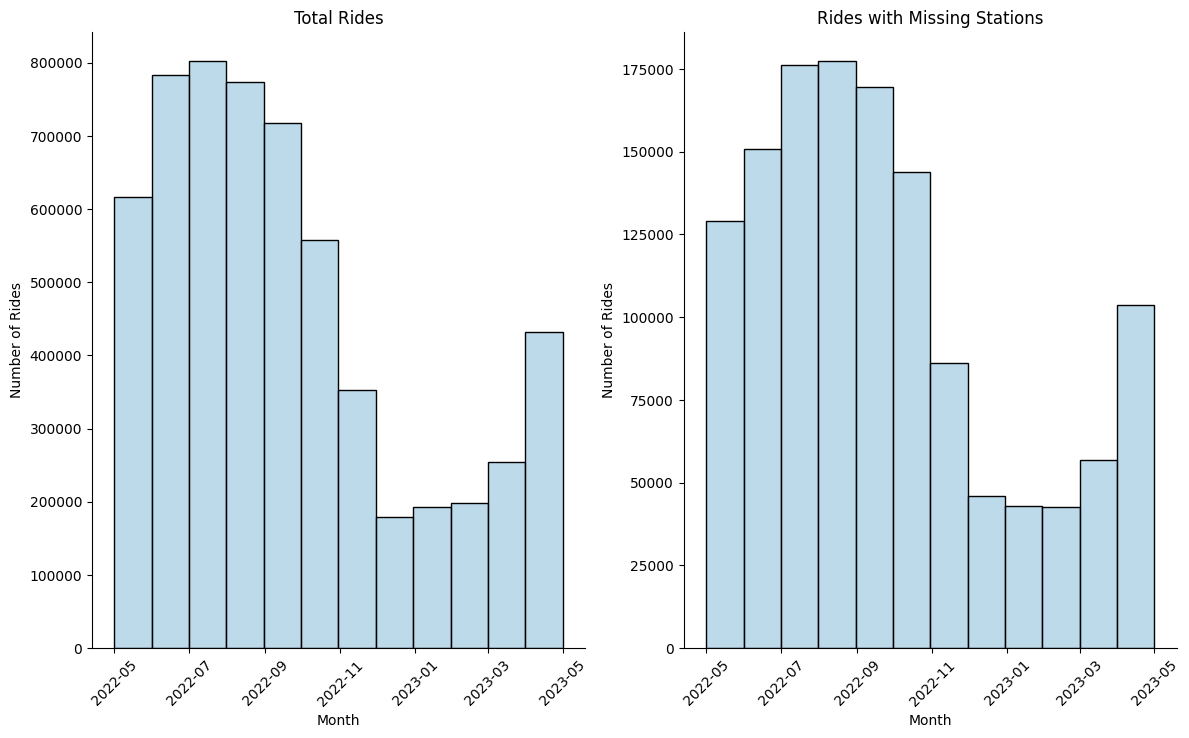

In [21]:
# Create new dataframe with missing stations
missing_stations = df[(df['start_station_id'].isnull()) | (df['end_station_id'].isnull())]

# Create histograms to look at distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
sns.set_palette('Paired')

# Histogram of all rides
sns.histplot(df['started_at'], bins=12, ax=axes[0])
axes[0].set_title('Total Rides')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Rides')
axes[0].set_xticklabels(labels=axes[0].get_xticklabels(), rotation=45)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Histogram of missing stations data
sns.histplot(missing_stations['started_at'], bins=12, ax=axes[1])
axes[1].set_title('Rides with Missing Stations')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Rides')
axes[1].set_xticklabels(labels=axes[1].get_xticklabels(), rotation=45)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.show()

In [4]:
# Drop rows with missing stations
df.dropna(subset=['start_station_name', 'start_station_id', 'end_station_name', 'end_station_id'], inplace=True)
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 4533999 entries, 0 to 426589
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   ride_id             4533999 non-null  object        
 1   rideable_type       4533999 non-null  category      
 2   started_at          4533999 non-null  datetime64[ns]
 3   ended_at            4533999 non-null  datetime64[ns]
 4   start_station_name  4533999 non-null  object        
 5   start_station_id    4533999 non-null  object        
 6   end_station_name    4533999 non-null  object        
 7   end_station_id      4533999 non-null  object        
 8   start_lat           4533999 non-null  float64       
 9   start_lng           4533999 non-null  float64       
 10  end_lat             4533999 non-null  float64       
 11  end_lng             4533999 non-null  float64       
 12  member_casual       4533999 non-null  category      
 13  duration          

### Outlier Check
The data was checked for outliers. 328 rows were found with 0 or negative duration and 100 rows were found with duration greater than 24 hours (1440 minutes). There were also 8 rows with end latitude and longitude values equal to 0. The rows were removed and the resulting dataframe contained **4,533,563** rows.

In [23]:
# Summary of all columns
df.describe(include='all')

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,duration
count,4533999,4533999,4533999,4533999,4533999,4533999,4533999,4533999,4.533999e+06,4.533999e+06,4.533999e+06,4.533999e+06,4533999,4.533999e+06
unique,4533999,3,NaN,NaN,1613,1282,1651,1292,NaN,NaN,NaN,NaN,2,NaN
top,EC2DE40644C6B0F4,classic_bike,NaN,NaN,Streeter Dr & Grand Ave,13022,Streeter Dr & Grand Ave,13022,NaN,NaN,NaN,NaN,member,NaN
freq,1,2639080,NaN,NaN,70849,70849,72327,72327,NaN,NaN,NaN,NaN,2742885,NaN
mean,NaN,NaN,2022-09-18 05:55:25.043074048,2022-09-18 06:11:58.661472,NaN,NaN,NaN,NaN,4.190175e+01,-8.764498e+01,4.190202e+01,-8.764509e+01,NaN,1.705459e+01
min,NaN,NaN,2022-05-01 00:00:06,2022-05-01 00:05:17,NaN,NaN,NaN,NaN,4.164850e+01,-8.783332e+01,0.000000e+00,-8.783000e+01,NaN,-1.680000e+02
25%,NaN,NaN,2022-07-01 16:33:53,2022-07-01 16:50:27.500000,NaN,NaN,NaN,NaN,4.188103e+01,-8.765839e+01,4.188103e+01,-8.765862e+01,NaN,6.000000e+00
50%,NaN,NaN,2022-08-26 17:22:56,2022-08-26 17:40:57,NaN,NaN,NaN,NaN,4.189680e+01,-8.764189e+01,4.189745e+01,-8.764288e+01,NaN,1.100000e+01
75%,NaN,NaN,2022-11-07 07:47:27.500000,2022-11-07 07:57:32,NaN,NaN,NaN,NaN,4.192877e+01,-8.762858e+01,4.192889e+01,-8.762858e+01,NaN,1.900000e+01
max,NaN,NaN,2023-04-30 23:58:48,2023-05-01 08:06:56,NaN,NaN,NaN,NaN,4.206487e+01,-8.752531e+01,4.206485e+01,0.000000e+00,NaN,3.203600e+04


In [43]:
# Find outliers
under = df[df['duration'] <= 0].shape[0]
over = df[df['duration'] >= 1440].shape[0]
zerocoord = df[(df['end_lng'] == 0) | (df['end_lat'] == 0)].shape[0]

print(f'Number of rows with 0 or negative duration: {under}')
print(f'Number of rows with duration over 24 hours: {over}')
print(f'Number of rows with latitude or longitude equal to 0: {zerocoord}')

Number of rows with 0 or negative duration: 328
Number of rows with duration over 24 hours: 100
Number of rows with latitude or longitude equal to 0: 8


In [5]:
# Remove outliers
df = df[(df['duration'] > 0) & (df['duration'] < 1440)]
df = df[(df['end_lng'] != 0) | (df['end_lat'] != 0)]
df.shape

(4533563, 14)

## Analysis
After the data was cleaned, I went on to create visualizations and look for trends in the data. I started by looking at the distribution of member rides and casual rides. I created a pie chart and found that about 60% of the rides were from members and 40% were from casual riders.

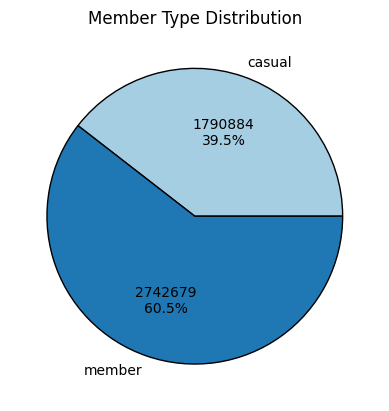

In [6]:
# Count and median of members vs. casual riders
members_agg = df.groupby('member_casual')['duration'].agg(Count='count', Median='median').reset_index()

# Pie chart of member types
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{absolute:d}\n{pct:.1f}%"
colors = sns.color_palette('Paired')

plt.pie(members_agg['Count'], labels=members_agg['member_casual'], autopct=lambda pct: func(pct, members_agg['Count']), colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth': 1})


# Add a title
plt.title('Member Type Distribution')
plt.show()

Next, I wanted to see if there were any differences in duration between the two types of riders. I created a boxplot and found that casual riders tend to have a longer ride duration compared to members. This could be because casual riders are more likely to use the bikes for leisure or recreational activities, which are not time-constrained, while members might use the bikes more for commuting, which is usually time-constrained. 

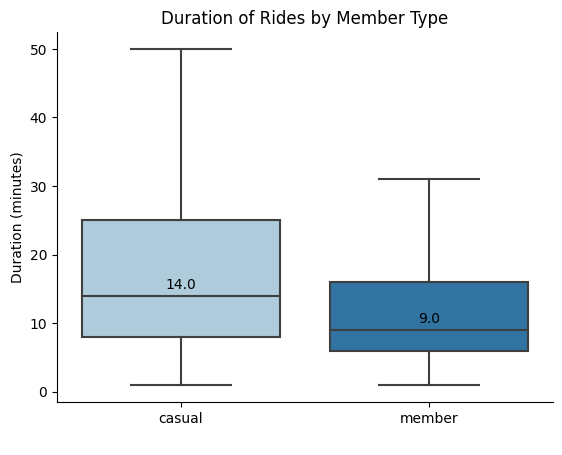

In [10]:
# Count and median of members vs. casual riders
members_agg = df.groupby('member_casual')['duration'].agg(Count='count', Median='median')

# Create duration member type boxplot
box = sns.boxplot(x=df['member_casual'], y=df['duration'], showfliers=False, palette='Paired')

# Annotate median values
for i in range(len(members_agg.Median)):
    box.annotate(members_agg.Median[i], xy=(i, members_agg.Median[i]+1), ha='center')

# Set title and axis labels
plt.title('Duration of Rides by Member Type')
plt.xlabel(' ')
plt.ylabel('Duration (minutes)')
sns.despine()

plt.show()

Next, I wanted to see which bike station was being used the most and by which type of rider. I also wanted to use the geospatial data to plot the stations on a map to look for possible patterns. While preparing the data to plot, I found that many stations did not have a unique latitude/longitude which made it difficult to plot on a map. I decided to pull live station data from the [GBFS JSON Feed](https://gbfs.divvybikes.com/gbfs/gbfs.json) on the Divvy website and create a dataframe with unique station names and coordinates. I then merged the newly created dataframe with a dataframe of the top stations; the resulting dataframe contained the top 10 stations by count along with their corresponding unique coordinates. 

After plotting the stations on a map and creating a barplot to show the top 10 stations, I found that the Streeter Dr & Grand Ave station had the most rides and a majority of the rides were from casual riders. I also found that stations with more casual riders were located on the lakefront as opposed to stations with more members which were located closer to the center of the city. 

In [15]:
# Subset data
top_stations = df[['start_station_name', 'start_lat', 'start_lng', 'member_casual']]
# Rename columns
top_stations = top_stations.rename(columns={'start_station_name': 'name', 'start_lat': 'lat', 'start_lng': 'lon'})
# group by station and check for unique coordinates
top_stations.groupby('name')[['lat', 'lon']].nunique().sort_values(by='lat', ascending=False).head(10)

,lat,lon
name,,
Clinton St & Madison St,7507,7478
Clinton St & Washington Blvd,6212,6355
Franklin St & Monroe St,6109,6126
St. Clair St & Erie St,5760,6046
Wells St & Elm St,5541,5233
Wabash Ave & Grand Ave,5527,5761
Clark St & Elm St,5478,5391
McClurg Ct & Ohio St,5469,5223
Canal St & Adams St,5424,5947


In [17]:
## Prepare geoplot data
# find top 10 stations by count
top_group = top_stations.groupby('name')['name'].agg(Count='count').sort_values(by='Count', ascending=False).head(10).reset_index()

# Obtain station data from live station feed
bike = requests.get('https://gbfs.divvybikes.com/gbfs/en/station_information.json')
bike_json = bike.json()
bike_data = bike_json['data']['stations']
station = pd.DataFrame(bike_data)

# create dataframe with station name and coordinates
stations = station[['name', 'lat', 'lon']]

# join top 10 stations dataframe with live station data
top_station = top_group.merge(stations, on='name', how='left')
top_station

,name,Count,lat,lon
0,Streeter Dr & Grand Ave,70837,41.892278,-87.612043
1,DuSable Lake Shore Dr & Monroe St,39347,41.880958,-87.616743
2,Michigan Ave & Oak St,37817,41.900960,-87.623777
3,DuSable Lake Shore Dr & North Blvd,37749,41.911722,-87.626804
4,Wells St & Concord Ln,35301,41.912133,-87.634656
5,Clark St & Elm St,33704,41.902973,-87.631280
6,Millennium Park,32824,41.881032,-87.624084
7,Kingsbury St & Kinzie St,32319,41.889177,-87.638506
8,Theater on the Lake,31559,41.926277,-87.630834
9,Wells St & Elm St,29649,41.903222,-87.634324


In [19]:
# Prepare barplot data
# create list of top 10 stations
ab = []
for l in top_station['name']:
    ab.append(l)
    
# filter out non top 10 stations
plot_data = top_stations[top_stations['name'].isin(ab)]

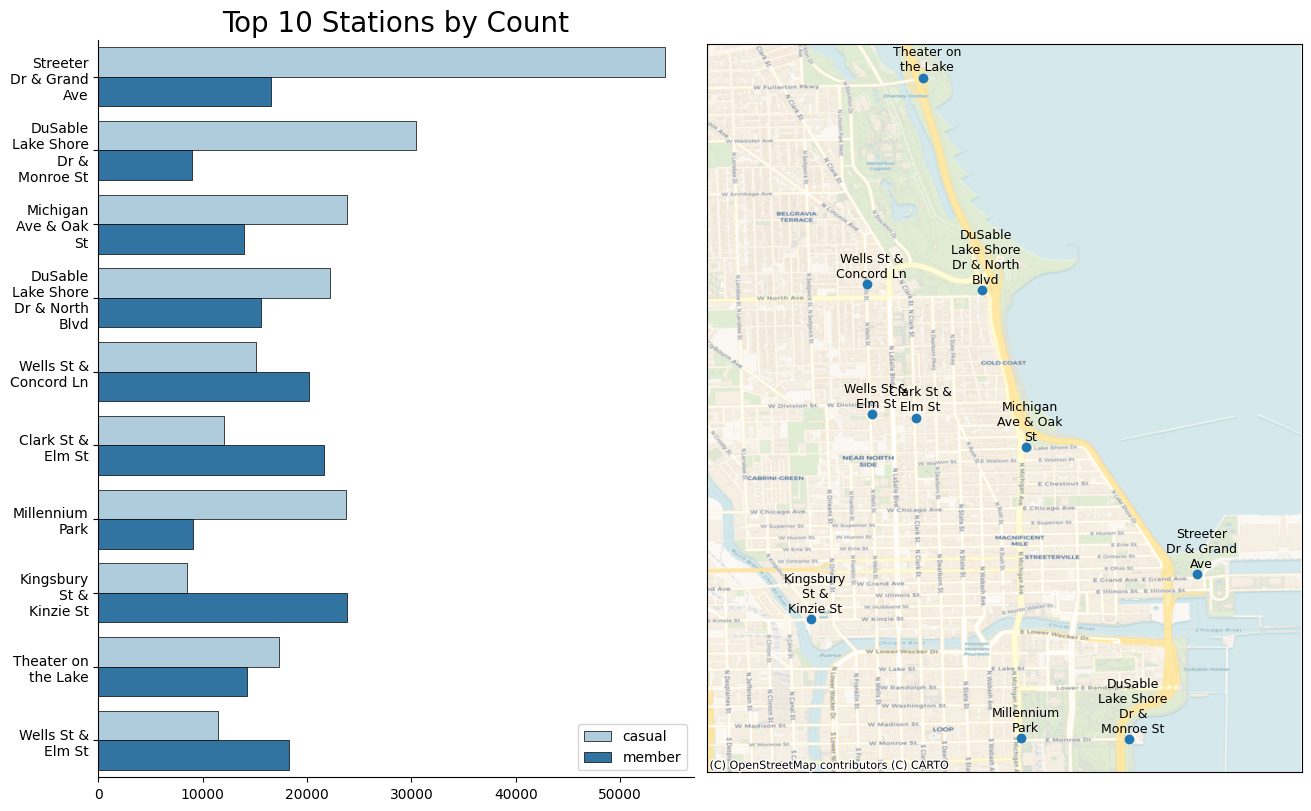

In [40]:
## Create 2 plots in 1 figure
fig, axes = plt.subplots(1, 2, figsize=(13,8), layout='constrained')

# BARPLOT
sns.countplot(ax=axes[0], data=plot_data, y='name', hue='member_casual', order=ab, palette='Paired', linewidth=0.5, edgecolor='black').legend(title=[])

# wrap y tick labels
y_labels = axes[0].get_yticklabels()
wrapped_labels = [textwrap.fill(label.get_text(), width=10) for label in y_labels]

# adjust plot design
axes[0].set_yticklabels(wrapped_labels)
axes[0].set_title('Top 10 Stations by Count', fontsize=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# GEOPLOT
gdf = gpd.GeoDataFrame(top_station, geometry=gpd.points_from_xy(top_station.lon, top_station.lat), crs="EPSG:4326")

ax1 = gdf.plot(ax=axes[1])
cx.add_basemap(ax1, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager)

# annotate map
for i, r in gdf.iterrows():
    wrapped_text = textwrap.fill(r['name'], width=10)
    ax1.annotate(wrapped_text, xy=(r.geometry.x, r.geometry.y), xytext=(3, 3), textcoords="offset points", fontsize=9, ha='center', va='bottom')

# adjust map width
buffer_ratio = 0.2
x_range = ax1.get_xlim()[1] - ax1.get_xlim()[0]
ax1.set_xlim(ax1.get_xlim()[0] - buffer_ratio * x_range, ax1.get_xlim()[1] + buffer_ratio * x_range)

# hide ticks
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()

Next, I wanted to look at when bikes were used the most/least and created barplots to look at the numbers of rides by month, day of the week, and hour. I found that both members and casual riders used bikes the most during the summer months (June, July, and August), while usage dipped to its lowest in the winter months (December, January, and February). I also found that casual riders tend to ride less during the weekdays and more on the weekends. However, the pattern was reversed for members, who had a higher number of rides during the weekdays and fewer on the weekends. When it came to the time of day, there were two distinct peaks in bike usage for members; one in the morning at 8AM and another in the evening at 5PM. For casual riders, the most significant number of rides was observed in the evening at 5PM.

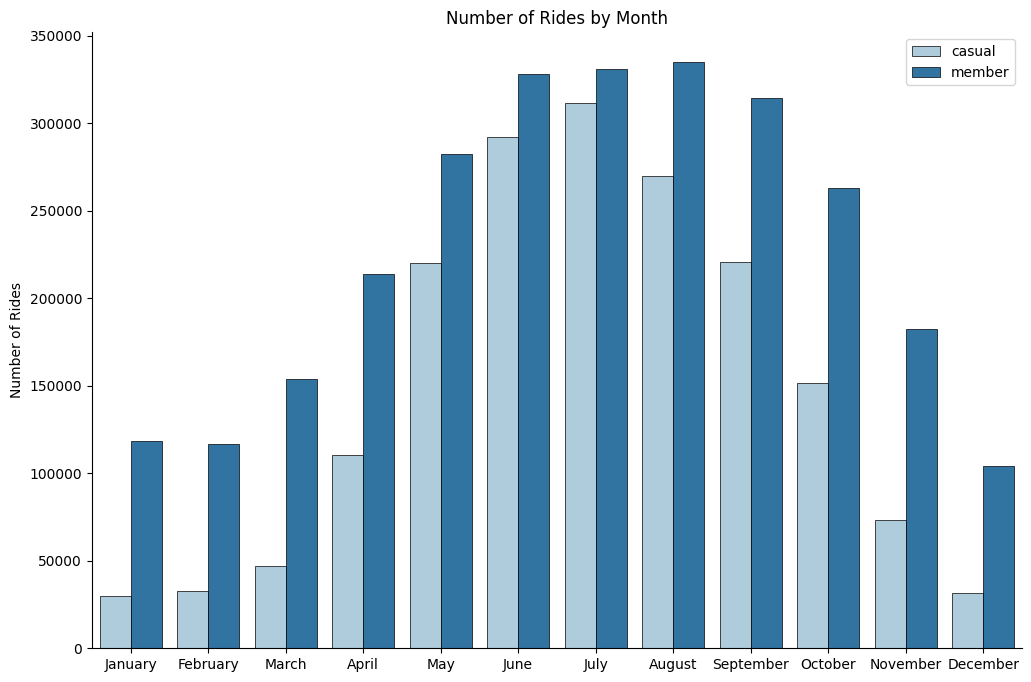

In [39]:
# Create bar plot number of rides by month
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.figure(figsize=(12, 8))
sns.countplot(x=df['started_at'].dt.month_name(), hue=df['member_casual'], order=month_order, palette='Paired', linewidth=0.5, edgecolor='black')
plt.title('Number of Rides by Month')
plt.legend(title='')
plt.xlabel('')
plt.ylabel('Number of Rides')
sns.despine()
plt.show()

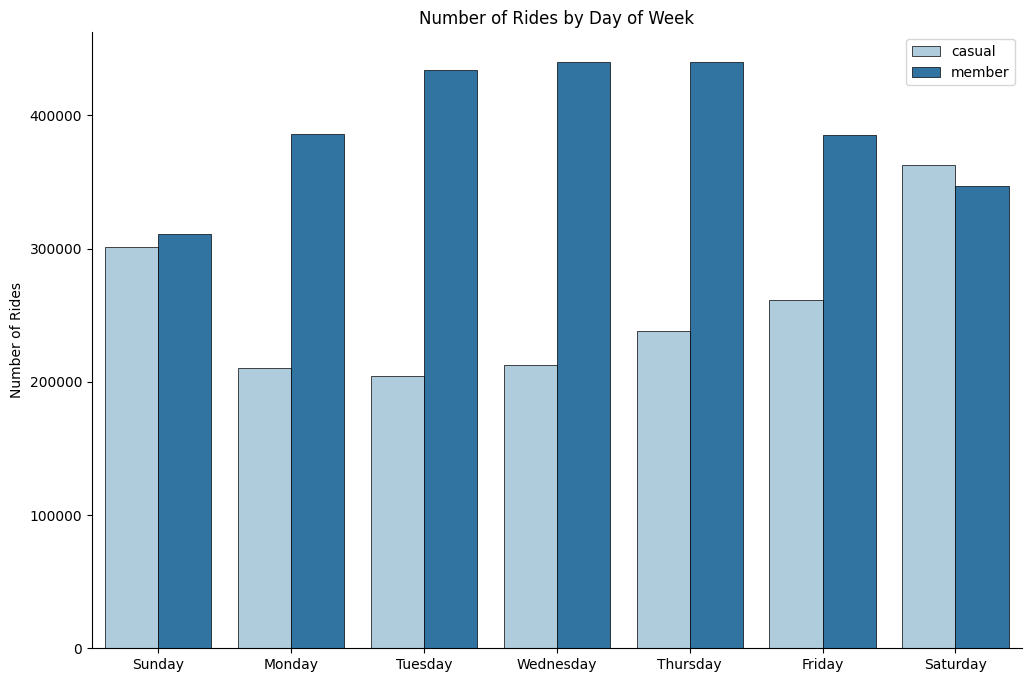

In [41]:
# Create bar plot number of rides by day of week
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plt.figure(figsize=(12, 8))
sns.countplot(x=df['started_at'].dt.day_name(), hue=df['member_casual'], order=day_order, palette='Paired', linewidth=0.5, edgecolor='black')
plt.title('Number of Rides by Day of Week')
plt.legend(title='')
plt.xlabel('')
plt.ylabel('Number of Rides')
sns.despine()
plt.show()

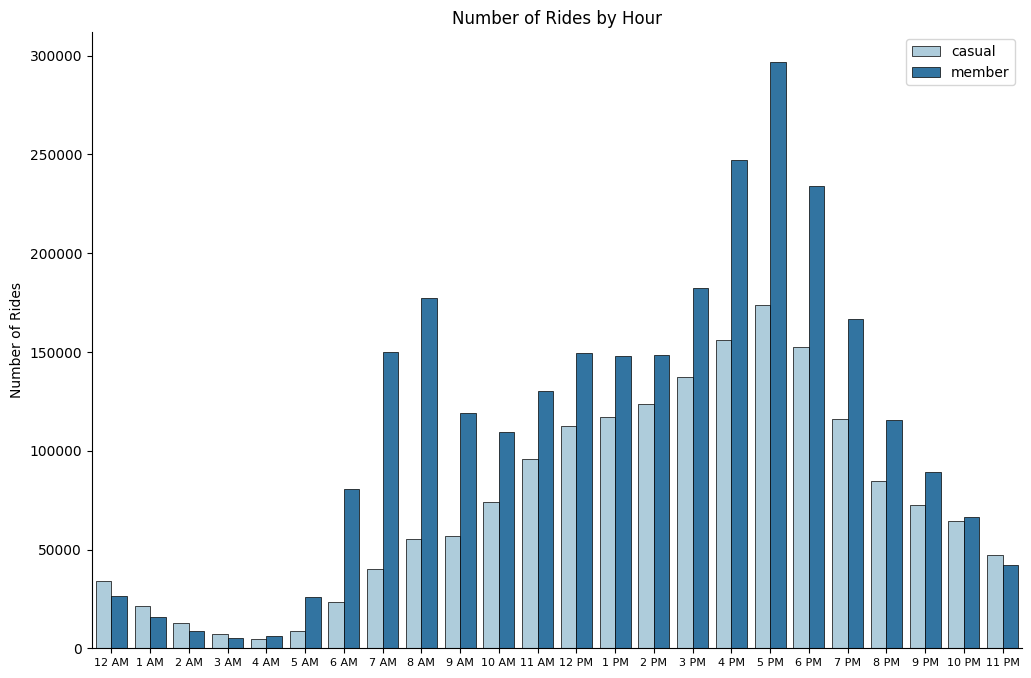

In [63]:
# Create bar plot number of rides by hour
hours = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM']
plt.figure(figsize=(12, 8))
sns.countplot(x=df['started_at'].dt.strftime('%#I %p'), hue=df['member_casual'], order=hours, palette='Paired', linewidth=0.5, edgecolor='black')
plt.title('Number of Rides by Hour')
plt.legend(title='')
plt.xlabel('')
plt.ylabel('Number of Rides')
plt.xticks(fontsize=8)
sns.despine()
plt.show()

## Insights and Recommendations
In conclusion, I was about to find many interesting trends in how casual riders and members use the bike share program:
- About 60% of the rides were from members and 40% were from casual riders.
- Casual riders tend to have a longer ride duration compared to members.
- Bike stations with more casual riders were located on the lakefront, but bike stations with more members were located closer to the center of the city.
- Members and casual riders use bikes the most during summer (June, July, August) and the least during winter (December, January, February).
- Casual riders use bikes more on the weekends and at 5PM
- Members use bikes more on the weekdays and at 8AM and 5PM
- Casual riders likely use bikes for leisure or recreational activities, while members likely use bikes for commuting.

Given the above insights, I would recommend the following to maximize the number of members:
- 